In [273]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [274]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {}'.format(device))
torch.device(device)

Using cuda


device(type='cuda')

In [275]:
#training variables

imgTransformSize = 224
#range of degrees +- to rotate
imgTransformRngRot = 5

train_dataset_path = './datasets/FoodTrain1'
valid_dataset_path = './datasets/FoodValidate1'

In [276]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(scale=(0.6, 1.0), size=(imgTransformSize,imgTransformSize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(imgTransformRngRot),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(imgTransformSize,imgTransformSize)),
    transforms.ToTensor()
])

In [277]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root = valid_dataset_path, transform = valid_transforms)

In [278]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ', labels)

In [279]:
#show_transformed_images(train_dataset)

In [280]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 32, shuffle = False)

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []


In [281]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(weights = None)
num_features = resnet18_model.fc.in_features
num_object_categories = 40 
resnet18_model.fc = nn.Linear(num_features, num_object_categories)
resnet18_model = resnet18_model.to(device)


resnet50_model = models.resnet50(weights = None)
num_features = resnet50_model.fc.in_features
num_object_categories = 40 
resnet50_model.fc = nn.Linear(num_features, num_object_categories)
resnet50_model = resnet50_model.to(device)


#The model we're actually using
usedModel = resnet50_model

In [282]:
loss_fn = nn.CrossEntropyLoss()

optimiser = optim.SGD(usedModel.parameters(), lr=0.05, momentum=0.9, weight_decay=0.003)

In [283]:
def train_network(model, train_loader, valid_loader, criterion, optimiser, n_epochs):

    epoch_valid_accuracy, epoch_valid_loss = 0, 0
    
    for epoch in range(n_epochs):
        #print("Epoch number %d (epoch + 1)")
        model.train()
        epoch_loss, epoch_accuracy = 0, 0
        totalImg = 0
        running_total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            totalImg += labels.size(0)

            optimiser.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()

            optimiser.step

            acc = ((outputs.argmax(dim=1) == labels).float().mean())

            running_total += (outputs.argmax(dim=1) == labels).sum().item()

            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        print('Epoch: {}, train accuracy: {:.2f}%, train loss: {:.4f}'.format(epoch+1, epoch_accuracy*100, epoch_loss))
        train_losses.append(epoch_loss.item())
        train_accs.append(epoch_accuracy.item())

        print("     -training set got %d out of %d images (%.3f%%)" % (running_total, totalImg, epoch_accuracy*100))


    model.eval()

    with torch.no_grad():

        for data in valid_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            valid_output = model(images)
            valid_loss = loss_fn(valid_output, labels)

            acc = ((valid_output.argmax(dim=1) == labels).float().mean())
            epoch_valid_accuracy += acc/len(valid_loader)
            epoch_valid_loss += valid_loss/len(valid_loader) 
            
    print('Epoch: {}, validation accuracy: {:.2f}%, valid loss: {:.4f}'.format(epoch+1, epoch_valid_accuracy*100, epoch_valid_loss))
    valid_losses.append(epoch_valid_loss.item())
    valid_losses.append(epoch_valid_accuracy.item())

    print("training complete")

    return model


In [284]:
#model = train_network(resnet18_model, train_loader, valid_loader, loss_fn, optimiser, 10)
model = train_network(resnet50_model, train_loader, valid_loader, loss_fn, optimiser, 10)

Epoch: 1, train accuracy: 3.75%, train loss: 3.8183
     -training set got 6 out of 143 images (3.750%)
Epoch: 2, train accuracy: 4.38%, train loss: 3.8143
     -training set got 7 out of 143 images (4.375%)
Epoch: 3, train accuracy: 6.33%, train loss: 3.7820
     -training set got 9 out of 143 images (6.333%)
Epoch: 4, train accuracy: 4.46%, train loss: 3.8268
     -training set got 6 out of 143 images (4.458%)
Epoch: 5, train accuracy: 4.38%, train loss: 3.8501
     -training set got 7 out of 143 images (4.375%)
Epoch: 6, train accuracy: 5.08%, train loss: 3.8244
     -training set got 7 out of 143 images (5.083%)
Epoch: 7, train accuracy: 4.38%, train loss: 3.8190
     -training set got 7 out of 143 images (4.375%)
Epoch: 8, train accuracy: 5.71%, train loss: 3.8065
     -training set got 8 out of 143 images (5.708%)
Epoch: 9, train accuracy: 5.79%, train loss: 3.7899
     -training set got 7 out of 143 images (5.792%)
Epoch: 10, train accuracy: 4.38%, train loss: 3.8039
     -train

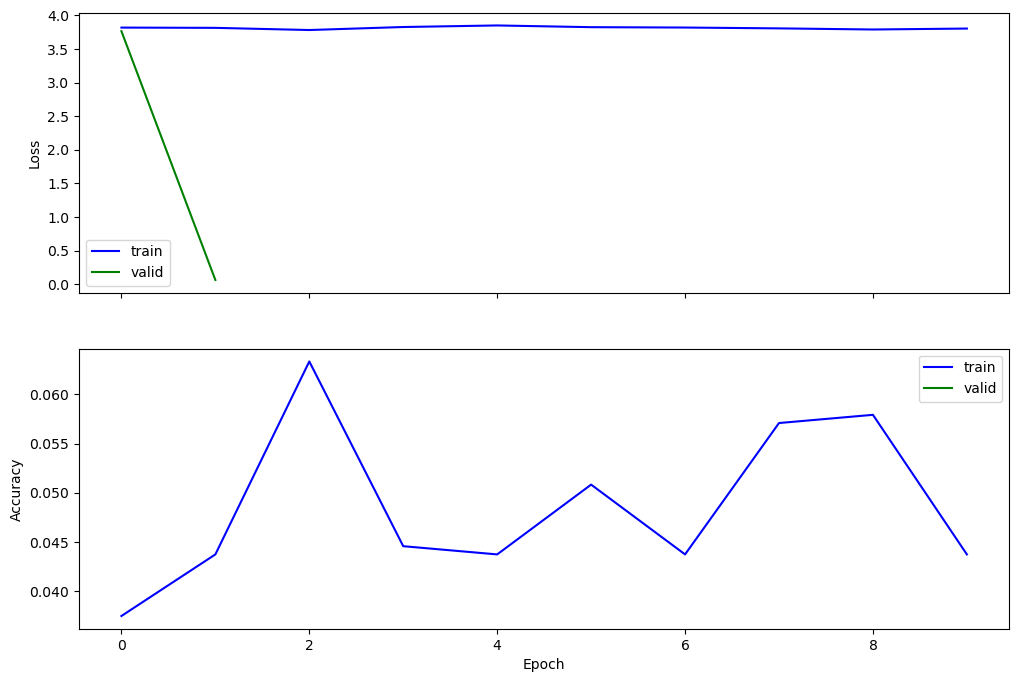

In [285]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
ax1.plot(train_losses, color='b', label='train')
ax1.plot(valid_losses, color='g', label='valid')
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accs, color='b', label='train')
ax2.plot(valid_accs, color='g', label='valid')
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()

In [286]:
valid_accuracy, valid_loss = 0, 0
with torch.no_grad():
    # Iterate through batches
    for data, label in valid_loader:
        # Move data to the used device
        data = data.to(device)
        label = label.to(device)
        # Forward pass
        valid_output_i = model(data)
        valid_loss_i = loss_fn(valid_output_i, label)
        # Compute metrics
        acc = ((valid_output_i.argmax(dim=1) == label).float().mean())
        valid_accuracy += acc/len(valid_loader)
        valid_loss += valid_loss_i/len(valid_loader)

print("valid loss: {:.4f}".format(valid_loss))
print("valid accuracy: {:.2f}%".format(valid_accuracy*100))

valid loss: 3.7536
valid accuracy: 6.25%
